In [3]:
import numpy as np
import vispy
import vispy.gloo as gloo
from vispy import app
from vispy.util.transforms import perspective, translate, rotate

# load the vispy bindings for the IPython notebook which enables webGL
%load_ext vispy.ipython

ImportError: No module named ipython

# Oriented Bounding Box

## Dependencies
* numpy
* matplotlib
* OpenCV

In [9]:
import itertools
import struct
import numpy as np
import cv2
import vispy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline



In [10]:
vispy.test()

----------------------------------------------------------------------
Skipping tests for backend pyqt4, not found (No module named PyQt4)
----------------------------------------------------------------------

----------------------------------------------------------------------
Skipping tests for backend pyqt5, not found (No module named PyQt5)
----------------------------------------------------------------------

----------------------------------------------------------------------
Skipping tests for backend pyside, not found (No module named PySide)
----------------------------------------------------------------------

----------------------------------------------------------------------
Skipping tests for backend pyglet, not found (No module named pyglet)
----------------------------------------------------------------------

----------------------------------------------------------------------
Skipping tests for backend glfw, not found (GLFW library not found)
-------------

RuntimeError: FAILURE

### Load point cloud data in KITTI format

In [23]:
def load_points_from_binary(file_name):
    x = []
    y = []
    z = []
    r = []

    value = b''
    pos = 0
    with open(file_name, 'rb') as f:
        byte = f.read(1)
        while byte:
            value += byte
            if len(value) == 4:
                point_coordinate = struct.unpack('>f', value)
                if pos == 0:
                    x += point_coordinate
                if pos == 1:
                    y += point_coordinate
                if pos == 2:
                    z += point_coordinate
                if pos == 3:
                    r += point_coordinate
                    pos = -1
                value = b''
                pos += 1
            byte = f.read(1)

    reflections = []
    points = []
    for i in range(len(x)):
        points.append([x[i], y[i], z[i], 1.0])
        reflections.append(r[i])

    points = np.array(points)
    reflections = np.array(reflections)
    return points, reflections

### PCA based oriented bounding box algorithm for data with arbitrary dimension

In [24]:
def oriented_bounding_box(points):
    p_mean = points.mean(axis=0)
    points -= p_mean
    cov = np.cov(points.T)
    w, v = np.linalg.eig(cov)
    
    ax_min_max = []
    for i in range(points.shape[1]):        
        vi = v[:, i]
        pi = points.dot(vi)
        ax_min_max.append([pi.min(), pi.max()])
    
    vertices = []
    for vertex in itertools.product(*ax_min_max):
        vertices.append(vertex)
    
    vertices = np.array(vertices)
    vertices = vertices.T
    vertices = v.dot(vertices)
    vertices += p_mean[:,np.newaxis]
    
    points += p_mean
    return vertices.T

### Brute forces algorithm to find minimum oriented bounding box

In [25]:
def oriented_bounding_box_2d_bf(points):
    
    area = float('inf')
    
    #e_x, e_y, px_min, px_max, py_min, py_max
    for theta in np.arange(0, 0.5*np.pi, np.pi/180):
        new_e_x = np.array([np.cos(theta), np.sin(theta)])
        new_e_y = np.array([-np.sin(theta), np.cos(theta)])
        
        px = points.dot(new_e_x)
        py = points.dot(new_e_y)
        
        new_px_min = px.min()
        new_px_max = px.max()
        new_py_min = py.min()
        new_py_max = py.max()
        new_area = abs(new_px_max - new_px_min) * abs(new_py_max - new_py_min)
        
        if new_area < area:
            e_x = new_e_x
            e_y = new_e_y
            px_min = new_px_min
            px_max = new_px_max
            py_min = new_py_min
            py_max = new_py_max
            area = new_area
    
    ax_min_max = [[px_min, px_max], [py_min, py_max]]
    
    vertices = []
    for vertex in itertools.product(*ax_min_max):
        vertices.append(vertex)
    
    vertices = np.array(vertices)
    vertices = vertices.T
    vertices = np.array([e_x, e_y]).T.dot(vertices)
    
    return vertices.T

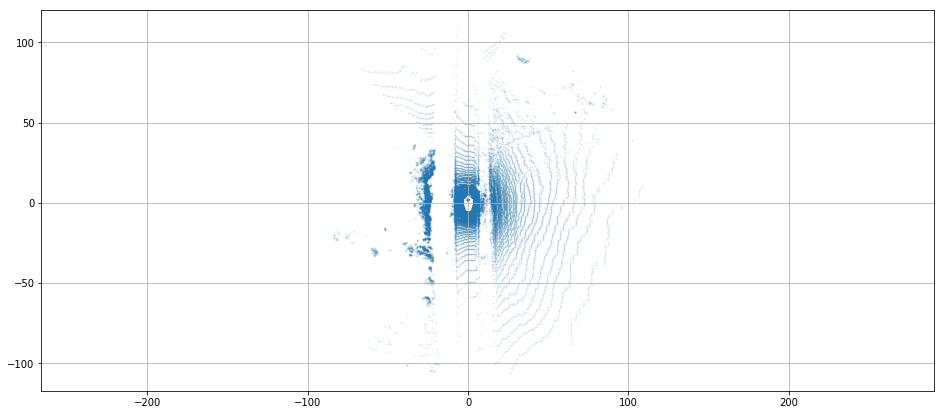

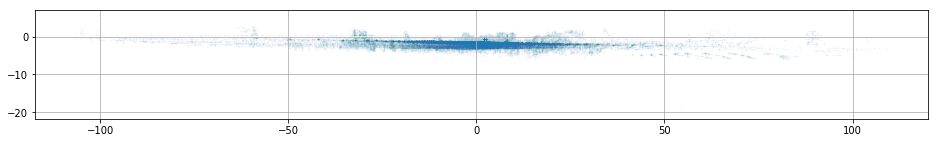

In [27]:
file_path = "/media/edo/DATA/aseml/kittiscans/1464252344989.bin"
#file_path = "002491.bin"
points, reflections = load_points_from_binary(file_path)
points = points[:, [0, 1, 2]]

plt.figure(figsize=(16,7))
plt.scatter(points[:,0], points[:,1], s=0.5, alpha=0.05)
plt.axis('equal')
plt.grid()

plt.figure(figsize=(16,2))
plt.scatter(points[:,1], points[:,2], s=0.5, alpha=0.025)
plt.axis('equal')
plt.grid()

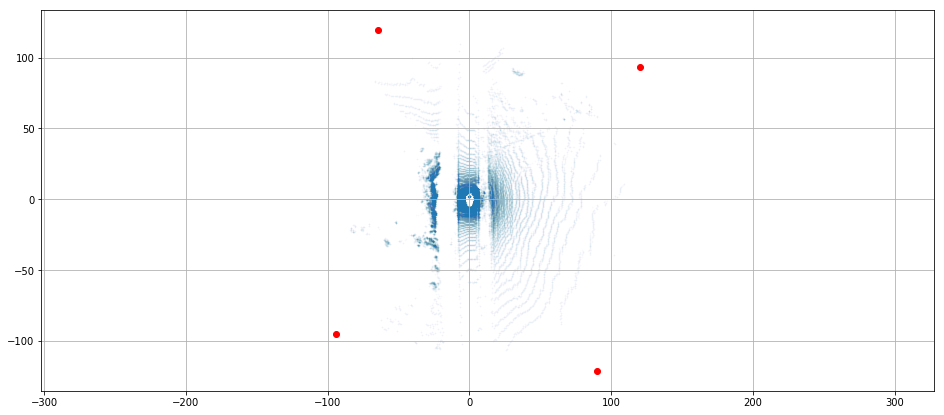

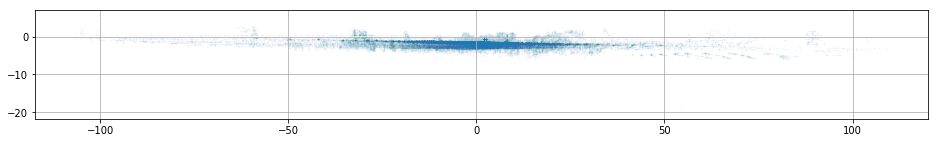

In [372]:
#points = np.random.multivariate_normal(np.array([-2,1]), np.diag([0.1,0.4]), 200)
#d1 = np.random.uniform(0.0, 1.0, size=(500, 2))
#d1[:,0] *= 100
#d2 = np.random.uniform(0.0, 1.0, size=(500, 2))
#d2[:,1] *= 25
#points = np.concatenate((d1, d2))

p1, p2, p3, p4 = oriented_bounding_box_2d_bf(points[:,[0,1]])

plt.figure(figsize=(16,7))

plt.scatter(points[:,0], points[:,1], s=0.5, alpha=0.025)
plt.scatter(p1[0], p1[1], c='red')
plt.scatter(p2[0], p2[1], c='red')
plt.scatter(p3[0], p3[1], c='red')
plt.scatter(p4[0], p4[1], c='red')


#plt.xlim(-50, 50)
#plt.ylim(-50, 50)
plt.axis('equal')
plt.grid()

plt.figure(figsize=(16,2))
plt.scatter(points[:,1], points[:,2], s=0.5, alpha=0.025)
plt.axis('equal')
plt.grid()

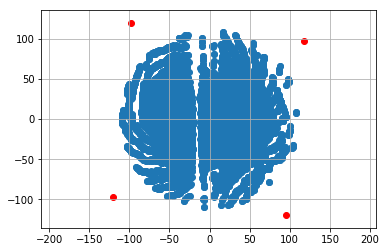

In [159]:
p1, p2, p3, p4 = oriented_bounding_box(points[:, [0,1]])

plt.scatter(points[:,0], points[:,1])
#plt.xlim(-0.5, 1.5)
#plt.ylim(-0.5, 1.5)
plt.axis('equal')
plt.grid()

plt.scatter(p1[0], p1[1], c='red')
plt.scatter(p2[0], p2[1], c='red')
plt.scatter(p3[0], p3[1], c='red')
plt.scatter(p4[0], p4[1], c='red')

# Ground Removal

In [352]:
def create_min_occupancy_grid(points, angle_resolution=1*np.pi / 180, range_resolution=0.2, range_max=50):
    
    max_z = -float('inf')
    min_z = float('inf')
    
    width = int(2*np.pi / angle_resolution)
    height = int(range_max / range_resolution)
    
    print width, height
    
    occupancy_grid = np.zeros((width, height))
    
    for point in points:
        x = point[0]
        y = point[1]
        z = point[2]
    
        phi = np.fmod(np.arctan2(x, y), 2*np.pi)
        r = np.sqrt(x**2 + y**2)
        
        u = int(phi / angle_resolution)
        v = int(r / range_resolution)
        
        #print u,v
        if u >= width - 1 or v >= height -1:
            continue
        
        old_z = occupancy_grid[u, v]
        
        if old_z > z:
            max_z = max(z, max_z)
            min_z = min(z, min_z)
            occupancy_grid[u, v] = z
        
    return occupancy_grid, min_z, max_z

In [353]:
def filter_points(points, occupancy_grid, angle_resolution=1*np.pi / 180, range_resolution=0.2, range_max=50):
    width, height = occupancy_grid.shape
    
    filtered_points = []
    for point in points:
        x = point[0]
        y = point[1]
        z = point[2]
    
        phi = np.fmod(np.arctan2(x, y), 2*np.pi)
        r = np.sqrt(x**2 + y**2)
        
        u = int(phi / angle_resolution)
        v = int(r / range_resolution)
        
        #print u,v
        if u >= width - 1 or v >= height - 1:
            continue
        
        filter_z = occupancy_grid[u, v]
        
        if z > filter_z:
            filtered_points.append(point)
        
    return np.array(filtered_points)

360 250


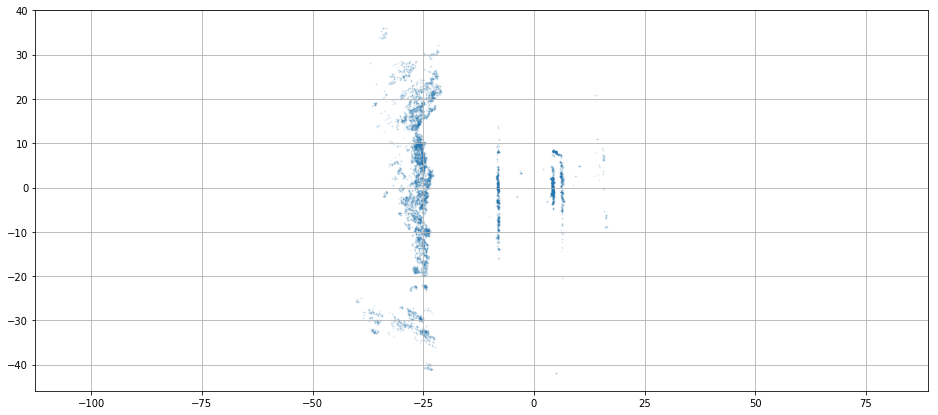

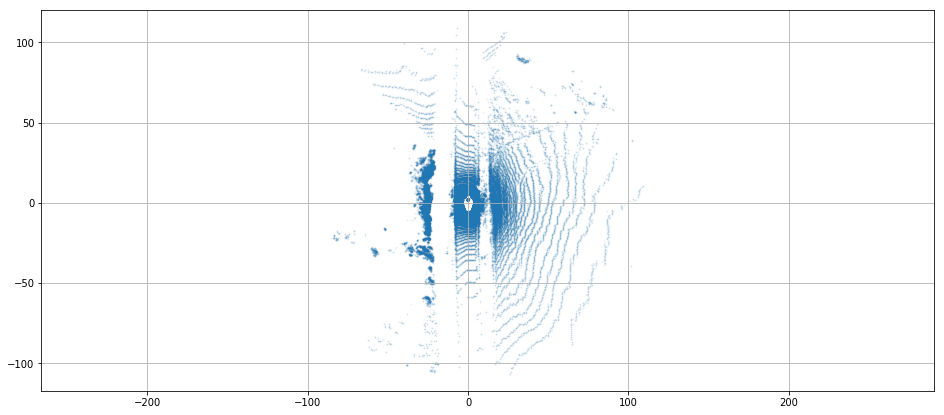

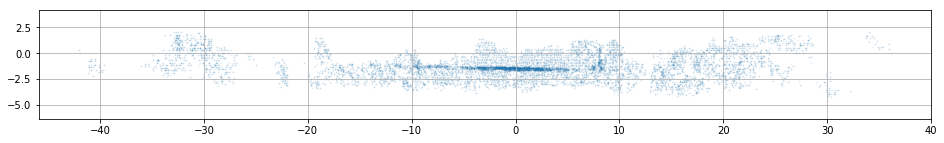

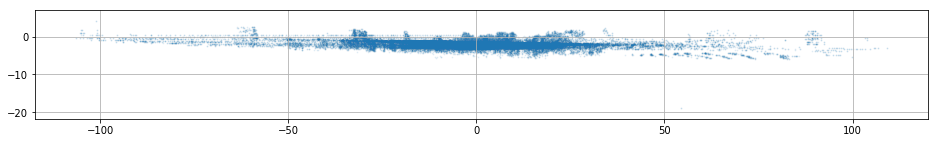

In [381]:
occ_grid, min_z, max_z = create_min_occupancy_grid(points)
smoothened_occ_grid = cv2.GaussianBlur(occ_grid, (3, 3), 0)
smoothened_occ_grid += 0.03
filtered_points = filter_points(points, smoothened_occ_grid)

plt.figure(figsize=(16,7))
plt.scatter(filtered_points[:,0], filtered_points[:,1], s=0.5, alpha=0.1)
plt.axis('equal')
plt.grid()

plt.figure(figsize=(16,7))
plt.scatter(points[:,0], points[:,1], s=0.5, alpha=0.1)
plt.axis('equal')
plt.grid()

plt.figure(figsize=(16,2))
plt.scatter(filtered_points[:,1], filtered_points[:,2], s=0.5, alpha=0.1)
plt.axis('equal')
plt.grid()

plt.figure(figsize=(16,2))
plt.scatter(points[:,1], points[:,2], s=0.5, alpha=0.1)
plt.axis('equal')
plt.grid()

360 250
-21.1495227814 -0.0109499394894
-21.1495227814 0.0


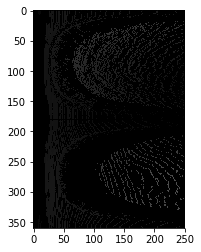

In [347]:
occ_grid, min_z, max_z = create_min_occupancy_grid(points)

print min_z, max_z
#occ_grid -= min_z
#occ_grid /= max_z - min_z
print occ_grid.min(), occ_grid.max()
plt.imshow(occ_grid, cmap='Greys', vmin=min_z, vmax=max_z)

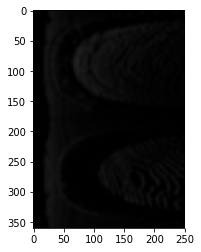

In [349]:
smoothened_occ_grid = cv2.GaussianBlur(occ_grid, (15, 15), 0)
#occ_grid *= (max_z - min_z) / 50
plt.imshow(smoothened_occ_grid, cmap='Greys', vmin=min_z, vmax=max_z)

# Old Stuff

In [5]:
points = np.random.multivariate_normal(np.zeros(3), np.diag([100,50,10]), 20)
points = np.random.uniform(size=(20, 3))

p_min, p_max = oriented_bounding_box(points)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], alpha=0.1)

lines = []

diff = p_max - p_min
dx = diff[0]
dy = diff[1]
dz = diff[2]

px = p_min[0]
py = p_min[1]
pz = p_min[2]

lines.append(np.array([[px,py,pz], [px+dx,py,pz]]))
lines.append(np.array([[px,py,pz], [px,py+dy,pz]]))
lines.append(np.array([[px,py,pz], [px,py,pz+dz]]))

lines.append(np.array([[px+dx,py,pz+dz], [px+dx,py,pz]]))
lines.append(np.array([[px+dx,py,pz+dz], [px,py,pz+dz]]))
lines.append(np.array([[px+dx,py,pz+dz], [px+dx,py+dy,pz+dz]]))

lines.append(np.array([[px,py+dy,pz+dz], [px,py,pz+dz]]))
lines.append(np.array([[px,py+dy,pz+dz], [px,py+dy,pz]]))
lines.append(np.array([[px,py+dy,pz+dz], [px+dx,py+dy,pz+dz]]))

lines.append(np.array([[px+dx,py+dy,pz], [px,py+dy,pz]]))
lines.append(np.array([[px+dx,py+dy,pz], [px+dx,py,pz]]))
lines.append(np.array([[px+dx,py+dy,pz], [px+dx,py+dy,pz+dz]]))

for l in lines:
    ax.plot([l[0][0], l[1][0]],
            [l[0][1], l[1][1]],
            [l[0][2], l[1][2]])
    
ax.scatter(p_min[0], p_min[1], p_min[2])
ax.scatter(p_max[0], p_max[1], p_max[2])
#ax.plot([p_min[0], p_max[0]], [p_min[1], p_max[1]], [p_min[2], p_max[2]])

ValueError: too many values to unpack (expected 2)